<a href="https://colab.research.google.com/github/arkaprabha10/Samsung-PRISM/blob/main/VAE_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade librosa

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Reshape,Conv2DTranspose,BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split

In [ ]:
lr = 0.0001
# epochs = 30000
batch_size = 32
input_dimension = 128*216
neural_network_dimension = 512
latent_variable_dimension = 2

In [ ]:
#speaker 1
Data_Path = '/content/drive/MyDrive/childrenSpeech/'
x_in = []



# y = []

count = 0
# duration = 5
with os.scandir(Data_Path) as entries:
  for entry in entries:
    if count == 3:
      break
    count +=1
#   #     with os.scandir(entry) as d:
#   #       if d.is_dir():
    with os.scandir(entry) as files:
      for file_ in files:
        data,samplerate = librosa.load(file_,duration = 10)
        data, index = librosa.effects.trim(data)
        mel_fbank = librosa.feature.melspectrogram(data, samplerate)
        x_in.append(mel_fbank.tolist())
#           # if file_.is_file():
#         data,samplerate = librosa.load(file_,duration = duration)
#         data, index = librosa.effects.trim(data)
#             # chroma_stft = librosa.feature.chroma_stft(y=data, sr=samplerate)
#             # rmse = librosa.feature.rms(y=data)
#             # spec_cent = librosa.feature.spectral_centroid(y=data, sr=samplerate)
#             # spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=samplerate)
#             # rolloff = librosa.feature.spectral_rolloff(y=data, sr=samplerate)
#             # zcr = librosa.feature.zero_crossing_rate(data)
#             # mfcc = librosa.feature.mfcc(y=data, sr=samplerate) 
#             # to_append += f' {0}'

#         mel_fbank = librosa.feature.melspectrogram(data, samplerate)

#         # mel_fbank = mel_fbank.flatten()

#         to_append = f''
#         for e in mel_fbank:
#           to_append += f'{e} '
#           print(len(e))
#           break
#         file = open('dataset_melfbank.csv', 'a', newline='')
#         with file:
#           writer = csv.writer(file)
#           writer.writecol(to_append.split())  
#         break
#         x.append(mel_fbank.flatten())
#         y.append(0)


print("Data successfully loaded!")
#speaker 2
# Data_Path = '/content/drive/My Drive/Speech Dataset/Libri_subset_Voice_conversion/84/'
# with os.scandir(Data_Path) as entries:
#   for entry in entries:
#     if entry.is_dir():
#       with os.scandir(entry) as files:
#         for file_ in files:
#           if file_.is_file():
#             data,samplerate = librosa.load(file_,duration = duration)
#             data, index = librosa.effects.trim(data)
#             # chroma_stft = librosa.feature.chroma_stft(y=data, sr=samplerate)
#             # rmse = librosa.feature.rms(y=data)
#             # spec_cent = librosa.feature.spectral_centroid(y=data, sr=samplerate)
#             # spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=samplerate)
#             # rolloff = librosa.feature.spectral_rolloff(y=data, sr=samplerate)
#             # zcr = librosa.feature.zero_crossing_rate(data)
#             # mfcc = librosa.feature.mfcc(y=data, sr=samplerate)
#             # to_append = f'{file_.name} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
#             # for e in mfcc:
#             #   to_append += f' {np.mean(e)}'
#             # to_append += f' {1}'
#             # file = open('dataset.csv', 'a', newline='')
#             # with file:
#             #   writer = csv.writer(file)
#             #   writer.writerow(to_append.split())
#             mel_fbank = librosa.feature.melspectrogram(data, samplerate)
#             x.append(mel_fbank.flatten())
#             y.append(1)



Data successfully loaded!


In [ ]:
input_length = 22050*5
def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=22050)[0] #, sr=16000
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)

            offset = np.random.randint(max_offset)
        else:
            offset = 0
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = preprocess_audio_mel_T(data)
    return data

In [ ]:
n_mels = 80
def preprocess_audio_mel_T(signal, sample_rate=22050, window_size=20, #log_specgram
                 step_size=10, eps=1e-10):
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)
    for i in range (0,len(pad_signal),frame_step):
      temp=pad_signal[i:frame_length+i]
      temp*=np.hanning(len(temp))
      for j in range(len(temp)):
        pad_signal[i+j]=temp[j]

    ans=librosa.feature.melspectrogram(y=pad_signal, sr=sample_rate,n_mels=80)

    return ans

In [ ]:
x_in = []
count = 0
Data_Path = '/content/drive/MyDrive/childrenSpeech/'
with os.scandir(Data_Path) as entries:
  for entry in entries:
    if count == 1:
      break
    count +=1
#   #     with os.scandir(entry) as d:
#   #       if d.is_dir():
    with os.scandir(entry) as files:
      for file_ in files:
        data = load_audio_file(file_)
        x_in.append(data.tolist())


In [ ]:
print(len(x_in[0]))

80


In [ ]:
#speaker 1
Data_Path = '/content/drive/My Drive/Speech Dataset/Libri_subset_Voice_conversion/174/'
x = []
y = []

duration = 2
with os.scandir(Data_Path) as entries:
  for entry in entries:
    if entry.is_dir():
      with os.scandir(entry) as files:
        for file_ in files:
          if file_.is_file():
            data,samplerate = librosa.load(file_,duration = duration)
            data, index = librosa.effects.trim(data)
            mel_fbank = librosa.feature.melspectrogram(data, samplerate, fmax = 20000, win_length = 512)
            to_append = ''    
            for e in mel_fbank:
              to_append += f' {e}'
            to_append += f' {0}'
            file = open('dataset_mel.csv', 'a', newline='')
            with file:
              writer = csv.writer(file)
              writer.writerow(to_append.split())


#speaker 2
Data_Path = '/content/drive/My Drive/Speech Dataset/Libri_subset_Voice_conversion/84/'
with os.scandir(Data_Path) as entries:
  for entry in entries:
    if entry.is_dir():
      with os.scandir(entry) as files:
        for file_ in files:
          if file_.is_file():
            data,samplerate = librosa.load(file_,duration = duration)
            data, index = librosa.effects.trim(data)
            mel_fbank = librosa.feature.melspectrogram(data, samplerate, fmax = 20000, win_length = 512)
            to_append = ''   
            for e in mel_fbank:
              to_append += f' {e}'
            to_append += f' {1}'
            file = open('dataset_mel.csv', 'a', newline='')
            with file:
              writer = csv.writer(file)
              writer.writerow(to_append.split())

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
from sklearn.preprocessing import MinMaxScaler
audio, sr= librosa.load("/content/drive/MyDrive/childrenSpeech/Ip18_A1_en_6_8_105/speakerIp18_A1_001001001003-promptIp18_A1_en_6_8_105.wav", duration = )
print(sr)
mfcc = librosa.feature.mfcc(audio)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(mfcc)
mfcc = scaler.transform(mfcc)

data = scaler.inverse_transform(mfcc)
wav = librosa.feature.inverse.mfcc_to_audio(data)


# ipd.Audio("/content/drive/My Drive/Speech Dataset/Libri_subset_Voice_conversion/84/121123/84-121123-0001.flac")
ipd.Audio(wav, rate = sr)

# Shows just MFCCs cannot be used as features to feed to neural network

NameError: ignored

In [ ]:
audio, sr = librosa.load("/content/drive/MyDrive/childrenSpeech/Ip18_A1_en_6_8_104/speakerIp18_A1_001001001003-promptIp18_A1_en_6_8_104.wav",duration = 10)
mel_fbank = librosa.feature.melspectrogram(audio)
print(mel_fbank.shape)
wav = librosa.feature.inverse.mel_to_audio(mel_fbank, sr)
ipd.Audio(wav, rate = sr)

(128, 431)


KeyboardInterrupt: ignored

In [ ]:
# print(len(header))

header = f''
for i in range(1,27649):
  header+= f'mel{i} '
data = pd.read_csv('dataset_melfbank.csv')

data.columns = header.split()

data = data.dropna()
from sklearn.preprocessing import MinMaxScaler

# x = data.iloc[:, :]


# print(data.head())


# print(np.isnan(x))
scaler = MinMaxScaler()
# # print(data)
x = scaler.fit_transform(np.array(data.iloc[:, :], dtype = float))

# mean = np.mean(x, axis=0)
# std = np.std(x, axis=0)+0.001
# x = (x - mean) / std
print(np.any(np.isnan(x)))


# s = np.amax(x)
# x = x/s




x_train = x[:170][:]
print(x_train.shape)

x_test = x[170:][:]

print(x_test.shape)
# x_train, x_test, y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

# print(x_train[0].shape)

False
(170, 27648)
(1203, 27648)


In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
#Encoder
inputs = Input(shape=(input_dimension,))
h = Dense(neural_network_dimension, activation='tanh')(inputs)

Dropout(0.2)
Mean_layer = Dense(latent_variable_dimension)(h)
Sigma_layer = Dense(latent_variable_dimension)(h)

Dropout(0.2)

#latent_layer
# latent_layer = Mean_layer + tf.exp(0.5*Sigma_layer)*epsilon
# model.add(latent_layer)

z = tf.keras.layers.Lambda(Sampling)([Mean_layer, Sigma_layer])

encoder = tf.keras.Model(inputs,[Mean_layer, Sigma_layer, z],name='encoder')
encoder.summary()


#Decoder layer
latent_inputs = Input(shape=(latent_variable_dimension,), name='z_sampling')
x = Dense(neural_network_dimension, activation='tanh')(latent_inputs)
outputs = Dense(input_dimension, activation='tanh')(x)
decoder = tf.keras.Model(latent_inputs, outputs)
outputs = decoder(encoder(inputs))
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

[print(i.shape, i.dtype) for i in vae.inputs]
[print(o.shape, o.dtype) for o in vae.outputs]
[print(l.name, l.input_shape, l.dtype) for l in vae.layers]


reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= input_dimension
kl_loss = 1 + Sigma_layer - tf.keras.backend.square(Mean_layer) - tf.keras.backend.exp(Sigma_layer)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',metrics = ['accuracy'])
# Decoder_hidden = model.add(Dense(neural_network_dimension, activation='tanh'))(z)
# Decoder_output = model.add(Dense(image_dimension, activation='sigmoid'))(Decoder_hidden)

# model.compile(optimizer='adam',metrics=['accuracy'])
# model.fit(x_train, batch_size = batch_size, epochs = epochs, validation_data= x_test)

In [ ]:
latent_dim = 128


tf.keras.regularizers.l2(l2 = 1e-4)
inputs = tf.keras.Input(shape=(80, 216, 1))
x = Conv2D(64, 3, activation="tanh", padding="same", kernel_regularizer='l2')(inputs)
BatchNormalization()
x = Conv2D(128, 3, activation="tanh", strides=2, padding="same", kernel_regularizer='l2')(x)
BatchNormalization()
x = Conv2D(256, 3, activation="tanh", strides=2, padding="same", kernel_regularizer='l2')(x)
BatchNormalization()
x = Flatten()(x)
x = Dense(512, activation="tanh", kernel_regularizer='l2')(x)
BatchNormalization()
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 216, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 80, 216, 64)  640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 40, 108, 128) 73856       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 20, 54, 256)  295168      conv2d_7[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = Dense(20 * 54 * 256, activation="tanh", kernel_regularizer='l2')(latent_inputs)
BatchNormalization()
x = Reshape((20, 54, 256))(x)
x = Conv2DTranspose(256, 3, activation="tanh", strides=2, padding="same", kernel_regularizer='l2')(x)
BatchNormalization()
x = Conv2DTranspose(128, 3, activation="tanh", strides=2, padding="same", kernel_regularizer='l2')(x)
BatchNormalization()
x = Conv2DTranspose(64, 3, activation="tanh", padding="same", kernel_regularizer='l2')(x)
BatchNormalization()
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same", kernel_regularizer='l2')(x)
BatchNormalization()
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 276480)            35665920  
_________________________________________________________________
reshape_2 (Reshape)          (None, 20, 54, 256)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 40, 108, 256)      590080    
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 80, 216, 128)      295040    
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 80, 216, 64)       73792     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 80, 216, 1)        577 

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 320 * 216
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
x_in = np.expand_dims(x_in, -1).astype('float32')
max = np.amax(x_in)
x_in = x_in/max



In [ ]:
# print(x_in.shape)
x_in = x_in*max 
x_in = np.reshape(x_in, (120, 80, 216, 1))

In [ ]:
x_train = x_in[:100]
print(x_train.shape)
x_test = x_in[100:]
print(x_test.shape)

(100, 80, 216, 1)
(20, 80, 216, 1)


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-8), metrics = ['accuracy'])

vae.fit(x_train,  epochs=100, batch_size=128)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 47911.3242 - reconstruction_loss: 47911.3242 - kl_loss: 1.1712e-06
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 46631.2539 - reconstruction_loss: 46631.2500 - kl_loss: 0.0037
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 25477.0645 - reconstruction_loss: 25476.2344 - kl_loss: 0.8299
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 525.3252 - reconstruction_loss: 522.7258 - kl_loss: 2.5993
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 476.7183 - reconstruction_loss: 473.5274 - kl_loss: 3.1909
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 507.1324 - reconstruction_loss: 503.7310 - kl_loss: 3.4014
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 527.0273 - reconstruction_loss: 523.4548 - kl_loss: 3.5725
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 539

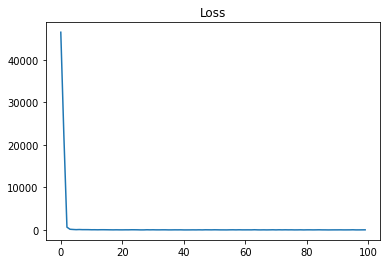

In [ ]:
plt.title('Loss')
plt.plot(vae.history.history['loss'])
plt.show()

In [ ]:
z_mean, z_log_var, z_sample = encoder.predict(x_test)

new_gen = decoder.predict(z_sample)

sample_1 = new_gen[3]
sample_1 = np.reshape(sample_1, (320, 216))

print(sample_1.shape)

(320, 216)


In [ ]:
sample_1 = sample_1 * max

wav = librosa.feature.inverse.mel_to_audio(sample_1, sr = 22050)

ipd.Audio(wav, rate = 22050)

# librosa.display.specshow(sample_1)
# plt.show()

In [ ]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



history = vae.fit(x_train, x_train,
        epochs=1000,
        validation_data=(x_test, x_test),
        callbacks = [PlotLosses()] )



Epoch 1/1000
4/6 [===================>..........] - ETA: 0s - loss: 1581.1451 - accuracy: 0.0234

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

(320, 216)


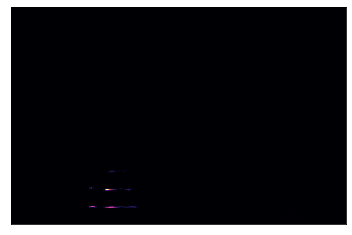

In [ ]:
input = x_test*max
input = np.reshape(input,(41,320,216))
print(input[0].shape)

librosa.display.specshow(input[0])
plt.show()
# input = np.reshape(320,216)
# wav = librosa.feature.inverse.mel_to_audio(input[0])

# ipd.Audio(wav, rate = 22050)

In [ ]:

# print(new_generated.shape)

# sample_1 = new_generated[2]

# sample_1 = sample_1.reshape(-1,216)

# print(sample_1.shape)

# real = x_test[2]
# real = real.reshape(-1,216)

# wav = librosa.feature.inverse.mel_to_audio(sample_1)

# ipd.Audio(wav, rate = 22050)


# librosa.display.specshow(sample_1)

# plt.show()

# librosa.display.specshow(real)




# librosa.display.specshow(real)
# plt.show()
# librosa.display.specshow(sample_1)
# plt.show()
# wav=librosa.feature.inverse.mel_to_audio(sample_1)

# ipd.Audio(wav, rate = 22050)

# # print(mean)



# #ORIGINAL DATA

# print("ORIGINAL DATA")
# data = pd.read_csv('dataset.csv')
# header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
# for i in range(1, 21):
#     header += f' mfcc{i}'
# header += ' label'
# header = header.split()
# data.columns = header
# data = data.drop(['filename'],axis = 1)
# data = data.drop(['label'], axis = 1)

# pd.set_option("max_columns", 7)
# print(data.head())




#GENERATED DATA

# print("GENERATED DATA")
# for i in range(0, new_generated.shape[0]):
#   file = open('newGenerated.csv', 'a', newline='')
#   with file:
#     writer = csv.writer(file)
#     writer.writerow(new_generated[i])



# header = 'chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
# for i in range(1, 21):
#     header += f' mfcc{i}'
# header = header.split()
# # print(len(header))
# data = pd.read_csv('newGenerated.csv')
# data.columns = header
# print(data.head())
# plt.figure(figsize=(20,4))
# for i in range(10):
#   ax = plt.subplot(2,10,i+1)
#   plt.plot(x_test[i])

#   ax = plt.subplot(2,10,i+11)
#   plt.plot(new_generated[i])
# plt.show()

In [ ]:
# header = 'filename'
# for i in range(1, 129):
#     header += f' mel{i}'
# header += ' label'
# header = header.split()
# # print(len(header))
# data = pd.read_csv('dataset_mel.csv')
# data.columns = header
# data = data.drop(['filename'],axis = 1)
# labels = data.iloc[:, -1]
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# encoder = LabelEncoder()

# y = encoder.fit_transform(labels)
# scaler = StandardScaler()
# # print(data)
# x = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
# x_train, x_test, y_train,y_test = train_test_split(x,y,test_size = 0.1,random_state = 42)

# print(x_train[0].shape)